##Data Science Tutorial
#### Sahil Goel, Salma Khairat, and Saima Ahmed

Drake is one of the most influential artists of our generation. With billions of people streaming his music, there’s little data about his audience and who finds his music relatable. Although this data is scarce, we are going to attempt to figure out if his music could be relatable to everyone by analyzing the themes and words in his lyrics. The main motivation for this is curiosity, but it could also be helpful to artists who want to understand how their music is being perceived based on their lyrics. The albums we chose are some of Drake’s most popular albums and they span from 2011 to 2021 so that we can include data from different eras of his musical career. Our null hypothesis is assuming that Drake’s lyrics cater more towards the female audience, 75% of the 130 songs that we analyze will be classified as “for women”. We will be testing this hypothesis in hopes of proving/disproving this sentiment. 

Note To Readers: As is common in hip-hop and rap culture, there is explicit language in the lyrics we have obtained. This explicit language shows up in our output and may also appear in our analysis. We felt that we should include these words uncensored as they reflect the culture of these genres of music in today's society and removing them would pose a significant barrier to an accurate analysis. We do not condone the use of this explicit language. 

## Preliminary Step


In [1]:
# Importing necessary libraries and downloading appropriate packages
import numpy as np
import pandas as pd
import nltk
import re
import random
import math
from pandas.tseries import offsets
from gensim.models import Word2Vec
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn import metrics
from sklearn.manifold import TSNE
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from nltk.stem.porter import *
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud
from gensim.corpora.dictionary import Dictionary
from gensim.models.ldamodel import LdaModel
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

## Obtaining Drake's Song Lyrics
In order to access the lyrics for each album we want to analyze we can use Genius, a website that holds official lyrics for popular songs/artists. Genius offers an API we can access through an individually generated token (https://docs.genius.com/#/getting-started-h1). Lyrics Genius is a python module that uses the Genius API which has pre-made functions for finding artists, songs, and lyrics. We decided to use Lyrics Genius and the Genius API because it is a verified website with accurate references and information. Since these tools already exist and have tons of documentation it was easier to implement and troubleshoot, as opposed to using a less well known source where we would have to scrape data ourselves page by page. Also, since we are working with well-known lyric data and Genius is a certified website, we did not encounter any issues with missing data. 
We first detected the albums we wanted to collect data from and analyzed them using the built in Genius search_album function. In order to get the song names of each album we created a function that takes an album object and looped through the individual songs. Once we had the song names, we could then go through and find the song objects using the built in search_song function. Once we had the song objects, we could then obtain the lyrics in the form of strings using the lyrics field of the song objects. 

In [2]:
# Installing tool to access Genius API, where we will obtain the lyrics
!pip install git+https://github.com/johnwmillr/LyricsGenius.git
from lyricsgenius import Genius

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/johnwmillr/LyricsGenius.git to /tmp/pip-req-build-6jwibwfm
  Running command git clone -q https://github.com/johnwmillr/LyricsGenius.git /tmp/pip-req-build-6jwibwfm
  Created wheel for lyricsgenius: filename=lyricsgenius-3.0.1-py3-none-any.whl size=44687 sha256=d02830e9915782836e41f8ba64c554541ae0b19c00bfa39caadcb5abbb3b75fe
  Stored in directory: /tmp/pip-ephem-wheel-cache-f1szc7eb/wheels/12/d5/2b/6b771ebb067bceb8816ec5eef0dd0d36bf069b18f03ac8ca20
Successfully built lyricsgenius


In [ ]:
# Accessing Genius API using our token and searching for 6 of Drake's albums
genius = Genius("mVRVsAuDeNkIUzqzTsZ3HcnUowYCvhQCtc1gf2WRM-iO46_7syYrCerNv8fNh6-0")
too_late = genius.search_album("If You're Reading This It's Too Late", "Drake")
take_care = genius.search_album("Take Care", "Drake")
views = genius.search_album("Views", "Drake")
more_life = genius.search_album("More Life", "Drake")
scorpion = genius.search_album("Scorpion", "Drake")
clb = genius.search_album("Certified Lover Boy", "Drake")

Searching for "If You're Reading This It's Too Late" by Drake...
Searching for "Take Care" by Drake...
Searching for "Views" by Drake...
Searching for "More Life" by Drake...
Searching for "Scorpion" by Drake...
Searching for "Certified Lover Boy" by Drake...


In [ ]:
# Getting song names from each album
def getSongNames(album):
  song_names = []
  for track in album.tracks:
    song_names.append(track.song.title)
  return song_names

too_late_song_names = getSongNames(too_late)
take_care_song_names = getSongNames(take_care)
views_song_names = getSongNames(views)
more_life_song_names = getSongNames(more_life)
scorpion_song_names = getSongNames(scorpion)
clb_song_names = getSongNames(clb)
print(too_late_song_names)
print(take_care_song_names)
print(views_song_names)
print(more_life_song_names)
print(scorpion_song_names)
print(clb_song_names)

In [ ]:
# Getting song objects for each song name
def getSongObjects(song_names):
  song_objects = []
  for song in song_names:
    song_objects.append(genius.search_song(song, "Drake"))
  return song_objects

too_late_songs = getSongObjects(too_late_song_names)
take_care_songs = getSongObjects(take_care_song_names)
views_songs = getSongObjects(views_song_names)
more_life_songs = getSongObjects(more_life_song_names)
scorpion_songs = getSongObjects(scorpion_song_names)
clb_songs = getSongObjects(clb_song_names)

In [ ]:
# Getting song lyrics from each song object
def getLyrics(song_objects):
  song_lyrics = []
  for song in song_objects:
    song_lyrics.append(song.lyrics)
  return song_lyrics

too_late_lyrics = getLyrics(too_late_songs)
take_care_lyrics = getLyrics(take_care_songs)
views_lyrics = getLyrics(views_songs)
more_life_lyrics = getLyrics(more_life_songs)
scorpion_lyrics = getLyrics(scorpion_songs)
clb_lyrics = getLyrics(clb_songs)

In [ ]:
# Testing code by printing part of a song
print(too_late_lyrics[1][0:200])

Energy Lyrics[Produced by Boi-1da & OB O'Brien]

[Intro: DJ Jah Walton & Drake]
Lickwood means "rewind" and gunshot means "forward"
You requested it, so we rewind
Yeah, way, way, way up
Turn it all up


##Cleaning and Organizing the Data

Now that we have the lyrics for each song for the 6 albums, we want to represent the data in a way that makes our data analysis effective. With python, Pandas is a common library used to store tabular data in the form of a data frame. Because many of the functions we will be using take data frames or lists as arguments, we decided to store our song lyrics in multiple data frames. We will be conducting analysis on all of the songs as a whole as well as the songs grouped by album, so we create data frames to store these subsets of data.


In [ ]:
# Puts all of the lyrics in one data frame
data = pd.DataFrame(too_late_lyrics + scorpion_lyrics + clb_lyrics 
                    + take_care_lyrics + views_lyrics + more_life_lyrics)
data.columns = ["lyrics"]

# Puts the lyrics in dataframes grouped by individual album
too_late_db = pd.DataFrame(too_late_lyrics)
too_late_db.columns = ["lyrics"]
scorpion_db = pd.DataFrame(scorpion_lyrics)
scorpion_db.columns = ["lyrics"]
clb_db = pd.DataFrame(clb_lyrics)
clb_db.columns = ["lyrics"]
take_care_db = pd.DataFrame(take_care_lyrics)
take_care_db.columns = ["lyrics"]
views_db = pd.DataFrame(views_lyrics)
views_db.columns = ["lyrics"]
more_life_db = pd.DataFrame(more_life_lyrics)
more_life_db.columns = ["lyrics"]

## Tokenizing the Song Lyrics
We used the sent_tokenize function under the NLTK we imported to tokenize all the words detected in each string of lyrics. The Natural Language Toolkit is a collection of python libraries geared towards working with human language data that we discussed in class. The nature of this problem involves working with lyrics and analyzing language and context, so we explored NLTK and found that the tokenizing services would help us to separate individual words. In our implementation we represented each array of tokens/words in our data frame as a sentence. We then preproccessed the text by removing nonalphabetic characters, lowercasing, and removing stopwords. The toolkit also offers a set of stop words we can access that exist in the human language, words such as “the”, “it”, “and”, words that do not contribute to overarching themes/meaning. In our circumstances we are dealing with song lyrics and the genius website includes words such as “lyrics” and “chorus” that we manually added. The stop words set also includes male and female pronouns that we manually removed from the list, we wanted to analyze the frequency of gendered pronouns because it will be a statistic that helps us to determine who the artist is referring to or singing about (male/female audience). 

In [ ]:
data["sentences"] = data["lyrics"].apply(sent_tokenize)
too_late_db["sentences"] = too_late_db["lyrics"].apply(sent_tokenize)
scorpion_db["sentences"] = scorpion_db["lyrics"].apply(sent_tokenize)
clb_db["sentences"] = clb_db["lyrics"].apply(sent_tokenize)
take_care_db["sentences"] = take_care_db["lyrics"].apply(sent_tokenize)
views_db["sentences"] = views_db["lyrics"].apply(sent_tokenize)
more_life_db["sentences"] = more_life_db["lyrics"].apply(sent_tokenize)

In [ ]:
# This tokenizes our song lyrics after preprocessing
def generate_tokens(song):
  new_text = re.sub("[^A-Za-z]"," ", song)
  tokens = new_text.lower().split()
  tokens = [el for el in tokens if el not in sw]
  # These words were dominating the topics and do not carry much meaning, so we remove them
  tokens = [el for el in tokens if el not in set(["yeah", "know", "like", "woah", "chorus", "verse", "produced", 
                                                  "lyrics", "get", "got", "say", "drake", "gotta", "tryna", "oh","pre", "intro"])]
  return " ".join(tokens).split()

# This version of generate tokens joins the tokens back together at the end, resulting in one string rather than a list of tokens 
def generate_tokens_2(song):
  new_text = re.sub("[^A-Za-z]"," ", song)
  t = new_text.lower().split()
  t = [el for el in t if el not in sw]
  # These words were dominating the topics and do not carry much meaning, so we remove them
  t = [el for el in t if el not in set(["yeah", "know", "like", "woah", "chorus", "verse", "produced", 
                                        "lyrics", "get", "got", "say", "drake", "gotta", "tryna", "oh", "pre", "intro"])]
  return " ".join(t)

# This version of generate tokens takes in a list of sentences instead
def generate_tokens_3(sentence_list):
    final_tokens = []
    for sentence in sentence_list:
        new_text = re.sub("[^A-Za-z]"," ", sentence)
        tokens = new_text.lower().split()
        tokens = [el for el in tokens if el not in sw]
        if tokens!=[]:
            final_tokens.append(tokens)
    return final_tokens

# We import a list of stopwords and remove the ones we think may actually be relevant
sw = set(stopwords.words("english"))
sw.remove("against")
sw.remove("below")
sw.remove("he")
sw.remove("her")
sw.remove("herself")
sw.remove("himself")
sw.remove("his")
sw.remove("own")
sw.remove("ours")

# We apply our generate_tokens functions to obtain clean tokens for our lyrics in each data frame
data["clean_tokens"] = data["lyrics"].apply(generate_tokens)
data["clean_tokens_2"] = data["sentences"].apply(generate_tokens_3)
too_late_db["clean_tokens"] = too_late_db["lyrics"].apply(generate_tokens)
scorpion_db["clean_tokens"] = scorpion_db["lyrics"].apply(generate_tokens)
clb_db["clean_tokens"] = clb_db["lyrics"].apply(generate_tokens)
take_care_db["clean_tokens"] = take_care_db["lyrics"].apply(generate_tokens)
views_db["clean_tokens"] = views_db["lyrics"].apply(generate_tokens)
more_life_db["clean_tokens"] = more_life_db["lyrics"].apply(generate_tokens)

## Examining Word Frequencies By Album (In Chronological Order)

Within rap and poetry, artists make decisions on what themes they want to emphasize in a piece they are working on. One of the ways to create this emphasis is by repeating certain words to get the point across. Analyzing word frequencies of Drake’s lyrics showed certain themes that he discussed in his albums. Because our hypothesis is focused on determining who can relate to Drake’s music, we decided to put the word frequencies into three categories: words that describe men and their interests, words that describe women and their interests, and words that are neutral (words that apply to both or neither). In rap culture, stereotypes about men and women’s interests explain how these lyrics should be perceived. Because of this, we will be using these stereotypes (even though we don’t condone them) to explain how these lyrics are meant to be portrayed by these rappers. These stereotypes are mere generalizations and are not applicable to a lot of people. That being said, because we are analyzing information within rap culture, we have to see this data from their lens to obtain an accurate result. For this analysis, we looked at the most frequent words that were mentioned 35 times or more. We chose this number arbitrarily because we believed that it was enough to show us the top words that he wanted to emphasize while getting rid of filler words that do not have meaning on their own. 

In [ ]:
""" We wanted to analyze the frequencies of the words that appeared in each album.
    We created a total dict and a dict for each of the albums to be able to 
    compare the albums with each other. We just went through all the words in 
    the tokens and counted each unique word
"""
total_freq = {}
take_care_freq = {}
too_late_freq = {}
views_freq ={}
more_life_freq = {}
scorpion_freq ={}
clb_freq = {}

for i, r in data.iterrows():
    for word in r["clean_tokens"]:
        if word in total_freq:
            total_freq[word] += 1
        else:
            total_freq[word] = 1

for i, r in take_care_db.iterrows():
    for word in r["clean_tokens"]:
        if word in take_care_freq:
            take_care_freq[word] += 1
        else:
            take_care_freq[word] = 1

for i, r in too_late_db.iterrows():
    for word in r["clean_tokens"]:
        if word in too_late_freq:
            too_late_freq[word] += 1
        else:
            too_late_freq[word] = 1

for i, r in views_db.iterrows():
    for word in r["clean_tokens"]:
        if word in views_freq:
            views_freq[word] += 1
        else:
            views_freq[word] = 1

for i, r in more_life_db.iterrows():
    for word in r["clean_tokens"]:
        if word in more_life_freq:
            more_life_freq[word] += 1
        else:
            more_life_freq[word] = 1

for i, r in scorpion_db.iterrows():
    for word in r["clean_tokens"]:
        if word in scorpion_freq:
            scorpion_freq[word] += 1
        else:
            scorpion_freq[word] = 1

for i, r in clb_db.iterrows():
    for word in r["clean_tokens"]:
        if word in clb_freq:
            clb_freq[word] += 1
        else:
            clb_freq[word] = 1

In [ ]:
""" Since we're focusing on the general frequency, we decided that we only want to 
    pay attention to the most frequent words and see if there is a correlation there
    that would support our hypothesis. We chose 35 words for each album because 
    that was the amount that removed a lot of filler words such as "yuh" or "ayy"
    which don't inheritely have any meaning.
"""
total_freq = {key:val for key, val in total_freq.items() if val >= 100}
take_care_freq = {key:val for key, val in take_care_freq.items() if val >= 35}
too_late_freq = {key:val for key, val in too_late_freq.items() if val >= 35}
views_freq = {key:val for key, val in views_freq.items() if val >= 35}
more_life_freq = {key:val for key, val in more_life_freq.items() if val >= 35}
scorpion_freq = {key:val for key, val in scorpion_freq.items() if val >= 35}
clb_freq = {key:val for key, val in clb_freq.items() if val >= 35}

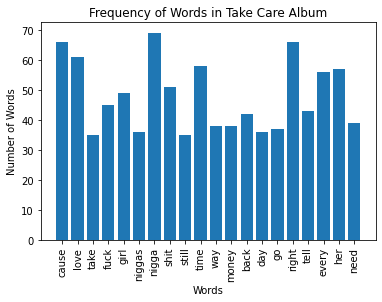

In [ ]:
# This graph shows all the frequencies of the take care album
words = list(take_care_freq.keys())
values = list(take_care_freq.values())
plt.bar(range(len(take_care_freq)), values, tick_label=words)

plt.xticks(rotation = 90)
plt.title("Frequency of Words in Take Care Album")
plt.xlabel("Words")
plt.ylabel("Number of Words")
plt.show()

For this album, we found that there are 20 words that were used that have frequencies of 35 times or more. Of those words, we realized that he mentions words like “love”, “her”, and “girl” so we will group similar words like those to the woman section. There are also words like the n word which will be placed in the category about men. Putting that in mind, we noticed that the women category had 3 words, the men category had 2 words and the neutral category had 15 words. 

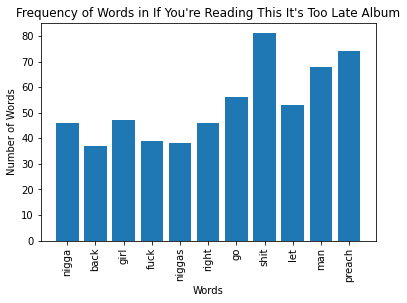

In [ ]:
# This graph shows all the frequencies of the too late album
words = list(too_late_freq.keys())
values = list(too_late_freq.values())
plt.bar(range(len(too_late_freq)), values, tick_label=words)

plt.xticks(rotation = 90)
plt.title("Frequency of Words in If You're Reading This It's Too Late Album")
plt.xlabel("Words")
plt.ylabel("Number of Words")
plt.show()

For this album there are 11 words that were used 35 times or more. Of those words, there are 3 that directly talk about or describe men (the n word and the word “man”), whereas there is only 1 word that describes a woman, which is the word “girl”. The rest of these words are neutral and they comprise 7 words, which is also the majority of the words. 

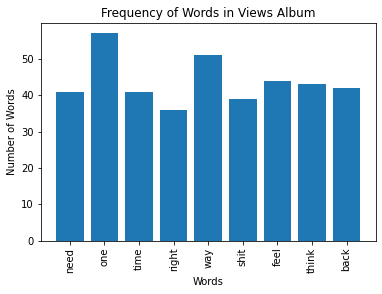

In [ ]:
# This graph shows all the frequencies for the views album
words = list(views_freq.keys())
values = list(views_freq.values())
plt.bar(range(len(views_freq)), values, tick_label=words)

plt.xticks(rotation = 90)
plt.title("Frequency of Words in Views Album")
plt.xlabel("Words")
plt.ylabel("Number of Words")
plt.show()

There are 9 words in this album that have word frequencies of 35 times or more. Of those words, there is one word that skews more towards the woman category and that is the word “feel” because socially it’s more acceptable for women to express how they feel. That being said, 1 is towards women and 0 is towards men. However, most are neutral.

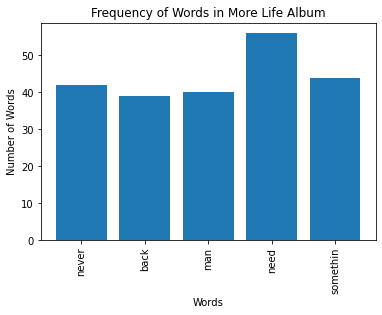

In [ ]:
# This graph shows all the frequencies for the more life album
words = list(more_life_freq.keys())
values = list(more_life_freq.values())
plt.bar(range(len(more_life_freq)), values, tick_label=words)

plt.xticks(rotation = 90)
plt.title("Frequency of Words in More Life Album")
plt.xlabel("Words")
plt.ylabel("Number of Words")
plt.show()

There are only 5 words in this album that have frequencies of 35 times or more. Of these words, the word “man” was used and the rest are all neutral. So, 1 is towards the men category and 4 was neutral. 

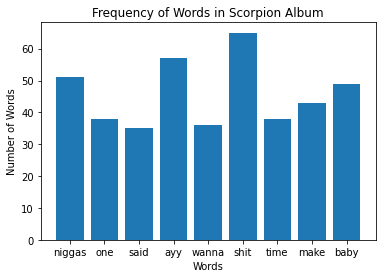

In [ ]:
# This graph shows all the frequencies of the scorpion album
words = list(scorpion_freq.keys())
values = list(scorpion_freq.values())
plt.bar(range(len(scorpion_freq)), values, tick_label=words)
plt.title("Frequency of Words in Scorpion Album")
plt.xlabel("Words")
plt.ylabel("Number of Words")
plt.show()

There are 9 words that were used in this album that have words that were mentioned 35 times or more. Of these words 1 could be used to categorize men and 1 could be used to categorize women. The rest are neutral words that don’t apply to any category. 

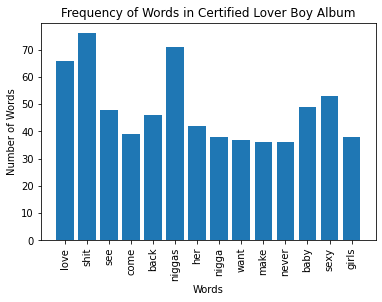

In [ ]:
# This graph shows all the frequencies of the clb album
words = list(clb_freq.keys())
values = list(clb_freq.values())
plt.bar(range(len(clb_freq)), values, tick_label=words)

plt.xticks(rotation = 90)
plt.title("Frequency of Words in Certified Lover Boy Album")
plt.xlabel("Words")
plt.ylabel("Number of Words")
plt.show()

With this album, there are 14 words that have frequencies of 35 times or more. Of these words, 5 could be categorized towards women and 2 could be categorized towards men. The rest would be neutral. 

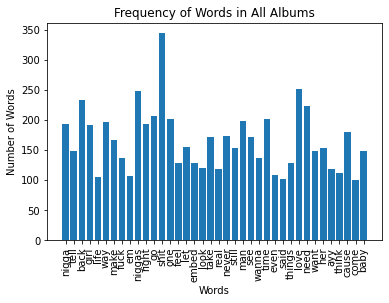

38
dict_keys(['nigga', 'tell', 'back', 'girl', 'life', 'way', 'make', 'fuck', 'em', 'niggas', 'right', 'go', 'shit', 'one', 'feel', 'let', 'embed', 'look', 'take', 'real', 'never', 'still', 'man', 'see', 'wanna', 'time', 'even', 'said', 'things', 'love', 'need', 'want', 'her', 'ayy', 'think', 'cause', 'come', 'baby'])


In [ ]:
# These are the total frequencies of all the albums and they're plotted accordingly
words = list(total_freq.keys())
values = list(total_freq.values())
plt.bar(range(len(total_freq)), values, tick_label=words)

plt.xticks(rotation = 90)
plt.title("Frequency of Words in All Albums")
plt.xlabel("Words")
plt.ylabel("Number of Words")
plt.show()
print(len(total_freq.keys()))
print(total_freq.keys())

When analyzing the total word frequencies that occur in all the albums, we notice that there are 38 words that occur 100 times or more. Of those words, 3 fall into the men category since they describe men and 4 fall into the category that could describe women. The neutral words were the most frequent (31 words) which shows that in these albums the themes that Drake has mentioned would be general themes that could relate to both men and women. Even within each individual category, the neutral words overrode the words that would stereotypically relate to men or women. 

## Word Embeddings on All 6 Albums (using Word2Vec)
Word2Vec is a python library that generates associations between words. In our case we wanted to find the relationship between the words we found and how they relate to the term “man”. Word2Vec uses neural network algorithms to create a vector association between the word we wish to model off of. The number assigned to each individual word is an indicator of that relationship. In this case, we created these vectors off of a 300 dimensional network. We modeled this based on a dimensional value between 100-400 so that the network would be large enough to show varied results. The higher the vector value, the closer it is in association to the term we modeled.   
In order to visualize the results, we had to simplify the dimensionality to something comprehensible. So, we projected the results onto a 2 dimensional plane using TSNE, which stands for T-distributed Stochastic Neighbor Embedding. This is a library under the sklearn module that is used to visualize high-dimensional data. This library helps to generate X and Y values related to each vector association which we plotted in a scatter plot. 


In [ ]:
# Generating 300-dimensional word embeddings using a window size of 5 using skip gram method
model = Word2Vec(data["clean_tokens_2"].sum(), size = 300, sg = 1, window = 5, min_count = 1, seed=1111)

In [ ]:
# Finding the 20 words most similar to "man" in the corpus 
model.wv.most_similar(positive=["man"], topn=20)

[('coming', 0.9993363618850708),
 ('zone', 0.9993249177932739),
 ('drizzy', 0.9993224143981934),
 ('dangerous', 0.9993219971656799),
 ('loved', 0.9993082880973816),
 ('proud', 0.9993046522140503),
 ('dead', 0.999297559261322),
 ('comin', 0.9992589950561523),
 ('rihanna', 0.9992565512657166),
 ('none', 0.9992398023605347),
 ('race', 0.9992387294769287),
 ('trouble', 0.9992361664772034),
 ('bridge', 0.9992058277130127),
 ('worse', 0.9992009401321411),
 ('wanted', 0.9991815686225891),
 ('matter', 0.9991762638092041),
 ('summer', 0.9991721510887146),
 ('deserve', 0.9991694092750549),
 ('hope', 0.999164879322052),
 ('follow', 0.999147891998291)]

In [ ]:
# Projecting 300 dimensions onto 2 dimensional plane using TSNE
vocab = list(model.wv.vocab)
X = model[vocab]
tsne = TSNE(n_components=2,random_state=1234)
X_tsne = tsne.fit_transform(X)
scatter_df = pd.DataFrame(X_tsne, index=vocab, columns=['x', 'y'])

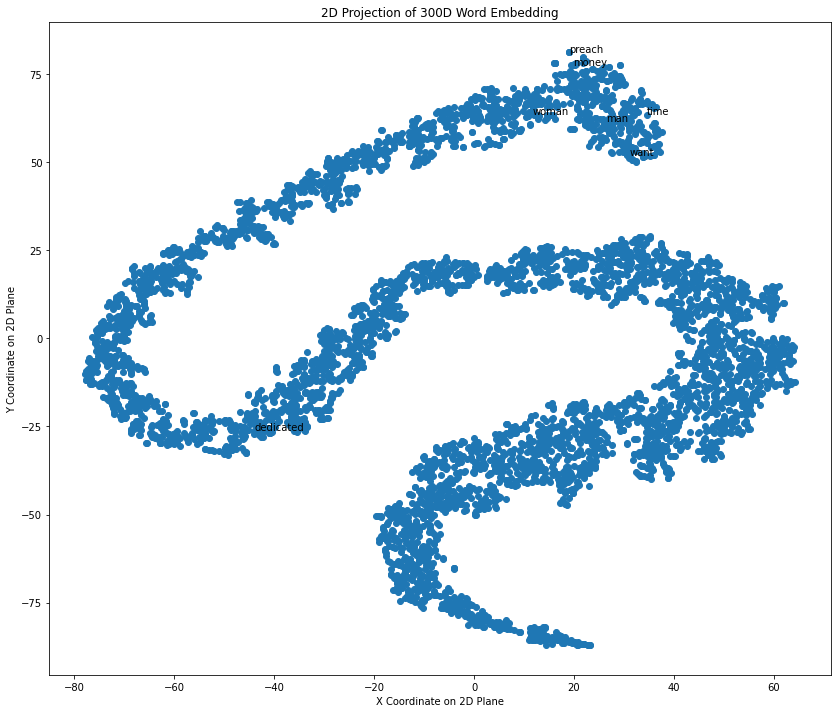

In [ ]:
# Plotting the 2 dimensional figure
fig = plt.figure(figsize=(14, 12))
ax = fig.add_subplot(1, 1, 1)
ax.scatter(scatter_df['x'], scatter_df['y'])

# Labeling some key points including "women" and "men"
for word, pos in scatter_df.iterrows():
  if word in ["man", "woman", "dedicated", "time", "money", "preach", "want"]:
    ax.annotate(word, pos)
plt.title("2D Projection of 300D Word Embedding")
plt.xlabel("X Coordinate on 2D Plane")
plt.ylabel("Y Coordinate on 2D Plane")
plt.show()

## Linear Support Vector Machine on All 6 Albums 
A linear support vector machine is a machine learning model that uses supervised learning. The Sci-Kit learn module contains a built-in function that allows us to train a model with labeled data and then make predictions on new data. With this model, we can attempt to classify Drake’s songs as being more geared towards men or women. One question that comes up with this model is what data to use as a training set. We could label all of Drake’s songs manually as being classified towards men or women and then randomly select a subset of songs to train on, testing the model on the corresponding untrained subset. However, we felt that this may lead to confirmation bias since we are trying to figure out who Drake’s music appeals to. As a result, we decided to find some websites that listed songs that were either empowering women or doing the opposite. In doing so, we realized that we found more songs that were empowering to women than songs that were misogynistic. To make sure that we trained the model well, we wanted to give the model an equal amount of songs from these categories, which were extreme opposites, so that Drake’s music could be labeled accurately. Something we noticed with the misogynistic songs too was that most of them were rap songs. We also know that most of Drake’s music is rap, so we didn’t want the machine to match Drake's songs with the misogynistic ones just because the language used in the rap genre is similar. So, of the songs that empowered women, we decided to randomly select songs to remove that were not rap so that there would be equal songs that empower women and that don't empower women. A lot of the songs that did empower women were also rap. So, since the genre is the same, the machine wouldn’t separate Drake’s songs solely based on the music genre since both categories have some rap songs and some songs from other genres. 


In [ ]:
# Getting the dataset

# https://www.harpersbazaar.com/culture/art-books-music/a18832473/best-feminist-women-empowerment-songs/
training_song_names_women = [ ("Run the World (Girls)", "Beyoncé"), 
                              ("You Don’t Own Me", "Lesley Gore"), 
                              ("Bad Reputation", "Joan Jett"), 
                              ("Bad Girls", "M.I.A."), 
                              ("Q.U.E.E.N.", "Janelle Monáe") , 
                              ("Independent Women - Part 1", "Destiny’s Child") , 
                              ("WAP", "Cardi B"), ("***Flawless", "Beyoncé"), 
                              ("Woman", "Kesha"), 
                              ("Doves in the Wind", "SZA"), ("Nasty", "Janet Jackson"), 
                              ("Respect", "Aretha Franklin"),  
                              ("Girl on Fire", "Alicia Keys"), ("Quiet", "MILCK"), 
                              ("Born This Way", "Lady Gaga"), ("Bodak Yellow", "Cardi B"), 
                              ("Just a Girl", "No Doubt"), ("Don’t Touch My Hair", "Solange"), 
                              ("Just Fine", "Mary J. Blige"), ("U.N.I.T.Y.", "Queen Latifah"), 
                              ("No Scrubs (With Rap)", "TLC"), ("PYNK", "Janelle Monáe"), 
                              ("Juice", "Lizzo"), ("​God is a woman", "Ariana Grande"),
                              ("Pussy Is God", "King Princess"), 
                              ("Girls Need Love", "Summer Walker"), 
                              ("Asexual Wellbeing", "Okay Kaya"), ("Poppin", "Rico Nasty"), 
                              ("Man! I Feel like a Woman!", "Shania Twain"), 
                              ("Girl Blunt", "Leikeli47"), ("In the Party", "Flo Milli")
                              ]

training_song_objects_women = []
for song in training_song_names_women:
  training_song_objects_women.append(genius.search_song(song[0], song[1]))

training_song_lyrics_women = getLyrics(training_song_objects_women)

# https://www.flavorwire.com/489278/25-of-musics-most-obnoxiously-misogynist-songs
# https://www.bustle.com/articles/137558-12-songs-that-are-actually-full-of-super-misogynistic-lyrics
training_song_names_men = [ ("It’s So Easy", "Guns N’ Roses"), ("Wrong Way", "Sublime"), 
                            ("Nookie", "Limp Bizkit"), ("A Man Needs a Maid", "Neil Young"),
                            ("Kim", "Eminem"), 
                            ("Tell That Mick He Just Made My List of Things to Do Today", 
                             "Fall Out Boy"), 
                            ("He Hit Me (It Felt Like a Kiss)", "The Crystals"), 
                            ("Triad (Demo) [2021 Remaster]", "David Crosby"),
                            ("Dominos", "The Big Pink"), ("Every Breath You Take", "The Police"), 
                            ("Me So Horny", "2 Live Crew"), ("Beware of Young Girls", "Dory Previn"),
                            ("Cocaine Blues (At Folsom Prison)", "Johnny Cash"), 
                            ("A Bitch Iz a Bitch", "N.W.A"), ("Under My Thumb", "The Rolling Stones"), 
                            ("Wild World", "Cat Stevens"),
                            ("Ain’t No Fun (If the Homies Can’t Have None)", "Snoop Dogg") , 
                            ("Run for Your Life", "The Beatles"), ("Blurred Lines", "Robin Thicke"), 
                            ("Follow You Home", "Nickelback"), 
                            ("I Will Possess Your Heart", "Death Cab for Cutie"), 
                            ("U.O.E.N.O", "Rocko"),
                            ("Outer Space", "Danny Brown"), ("Gold Digger", "Kanye West"), 
                            ("Better Than Revenge", "Taylor Swift"),
                            ("So Much Better", "Eminem"), ("Fine China", "Chris Brown"), 
                            ("Talk Dirty - Tribute to Jason Derulo and 2 Chainz", "Talk Dirty"), 
                            ("Bitches Ain’t Shit", "Dr. Dre"),
                            ("Love Game", "Eminem"), ("One Less Bitch", "N.W.A")
                            ]

training_song_objects_men = []
for song in training_song_names_men:
  training_song_objects_men.append(genius.search_song(song[0], song[1]))

training_song_lyrics_men = getLyrics(training_song_objects_men)

# Creating a list of classified labels for the corresponding songs (1 for women, 0 for men)
training_song_classifier = []
i = 0
while i < len(training_song_lyrics_women):
  training_song_classifier.append(1)
  i += 1
i = 0
while i < len(training_song_lyrics_men):
  training_song_classifier.append(0)
  i += 1

# Making a data frame for the test set
data_train = pd.DataFrame(training_song_lyrics_women + training_song_lyrics_men)
data_train.columns = ["lyrics"]
data_train["classification"] = training_song_classifier

In [ ]:
# Cleaning and tokenizing the text
data_train["clean_tokens"] = data_train["lyrics"].apply(generate_tokens_2)
data_train.head()

,lyrics,classification,clean_tokens
0,"Run the World (Girls) Lyrics[Intro]\nGirls, we...",1,run world girls girls run mutha girls run muth...
1,You Don’t Own Me Lyrics[Verse 1]\nYou don't ow...,1,own own one many toys own go boys tell tell pl...
2,Bad Reputation Lyrics[Verse 1]\nI don't give a...,1,bad reputation give damn bout reputation livin...
3,"Bad Girls Lyrics[Chorus]\nLive fast, die young...",1,bad girls live fast die young bad girls well l...
4,"Q.U.E.E.N. Lyrics[Intro: Janelle Monáe]\nGirl,...",1,q u e e n janelle mon e girl crazy let tell ja...


In [ ]:
# Getting the TF-IDF matrix
vect = TfidfVectorizer()
vect.fit(data_train["clean_tokens"])
songs_dtm = vect.transform(data_train["clean_tokens"])
songs_dtm_df = pd.DataFrame(songs_dtm.toarray(),
columns = vect.get_feature_names())

In [ ]:
# Creating the training and testing sets
X_train = songs_dtm_df.values
y_train = data_train["classification"]
# Verifying that our training and testing sets are the proper size
print(X_train.shape)
print(y_train.shape)
# This makes sense because we have 62 test songs

(62, 2848)
(62,)


In [ ]:
# Running the Linear Support Vector Machine
SVM = svm.SVC(kernel = "linear") 
SVM.fit(X_train, y_train) 

SVC(kernel='linear')

In [ ]:
# Testing the model (in our case we are interested in the # of Drake's songs classified as for men and # for women)
def predict_new_song(lyrics, model):
    cleaned_tokens = generate_tokens_2(lyrics)
    vect_txt = vect.transform([cleaned_tokens]).toarray()
    if model.predict(vect_txt)[0] == 0:
      return("men")
    elif model.predict(vect_txt)[0] == 1:
      return("women")
    else:
      return("ERROR")
  
drake_songs_for_men = 0
drake_songs_for_women = 0

for drake_song in data["lyrics"]:
  if predict_new_song(drake_song, SVM) == "women":
    drake_songs_for_women += 1
  elif predict_new_song(drake_song, SVM) == "men":
    drake_songs_for_men += 1

print("Number of Drake Songs for Women: " + str(drake_songs_for_women))
print("Number of Drake Songs for Men: " + str(drake_songs_for_men))
print("Proportion of Drake Songs for Women: " + str(drake_songs_for_women/len(data["lyrics"])))
print("Proportion of Drake Songs for Men: " + str(drake_songs_for_men/len(data["lyrics"])))

Number of Drake Songs for Women: 55
Number of Drake Songs for Men: 75
Proportion of Drake Songs for Women: 0.4230769230769231
Proportion of Drake Songs for Men: 0.5769230769230769


##Hypothesis Testing

We can construct a hypothesis test using the results from the linear support vector machine above. The null hypothesis is that Drake makes most of his music to appease women in an effort to paint himself in a positive light. Therefore, the proportion of Drake’s songs that are classified as “for women” is 0.75. The alternative hypothesis is that Drake does not make music that primarily serves to appease women, and therefore the proportion of Drake’s songs that are classified as “for women” is less than 0.75.


Null Hypothesis: proportion of Drake’s songs for women = 0.75

Alternative Hypothesis: proportion of Drake’s songs for women < 0.75

Type of test: Our binary data lends itself to a one sided z test using a binomial distribution. With the assumption that the distribution of our proportion statistic is approximately normal (using central limit theorem), we can use a normal distribution to approximate the binomial distribution to test our hypothesis. We will use a significance level (alpha) of 0.05 as this is standard practice. The mean and standard deviation are the two metrics that define a normal distribution, so we will calculate them based on known formulas that we learned in class.

In [ ]:
# Calculating the mean (n * p) and the standard deviation (sqrt(n * p * (1-p)))
mean = 130 * 0.75
sd = math.sqrt(130 * 0.75 * (1-0.25))
print("Mean: " + str(mean))
print("Standard Deviation: " + str(sd))

Mean: 97.5
Standard Deviation: 8.551315688243536


Using a cumulative density function as we did in class, we can calculate the probability that we observe the proportion of Drake’s songs for women is less than or equal to our observed proportion of 0.423, assuming that Drake makes a proportion of 0.75 of his music to appease women. This observed proportion corresponds to a count of 55 since 0.423 * 130 = 55. 


In [ ]:
# These functions were obtained from the lecture code

# We use this function to create our cumulative distribution function given the mean and sd
def normal_cdf(x: float, mu: float = 0, sigma: float = 1) -> float:
    return (1 + math.erf((x - mu) / np.sqrt(2) / sigma)) / 2

# We use this function to find the left tail probability that we observe a value at or below the lo value
def norm_below(lo: float, mu: float = 0, sigma: float = 1) -> float:
    return normal_cdf(lo, mu, sigma)

In [ ]:
# The probability that we got the results we did given that the null hypothesis is true
print(norm_below(55, mean, sd))

3.3477237665335835e-07


Using the norm_below function obtained from class, the probability of such an event is extremely small. Since this p value is approximately 0, which is less than our alpha of 0.05, we can reject the null hypothesis. We conclude that the proportion of Drake’s songs that are “for women” is significantly less than 0.75. In non-statistical terms, this means that Drake’s songs are not significantly skewed towards women.

##Conclusion

With Drake being a popular artist, we wanted to know if his music is truly for everyone. There is controversy over his target audience and we wanted to settle that dispute. Some people think that his music is created to solely appease women, so we decided to look into that and see what the data could tell us. First, we used a website called Genius to obtain all of Drake’s lyrics from his most popular albums. We then organized the data and parsed it so that it could be analyzed. After that, we were able to use that data to generate certain statistics such as word frequencies of all the albums. This did not support the null hypothesis because most of the frequent words that were used did not appeal to women over men. Then, we took the analysis a step further by creating a model that classifies Drake’s songs into one of two categories: a category that’s empowering to women and a category that is not. This model was trained on songs that were found online that we classified into the categories. To make sure that our hypothesis was tested, we used a binomial distribution and a one-sided z test. We discovered that the likelihood of Drake’s music mostly appeasing women was extremely unlikely. So, we concluded that Drake’s music was not only for women. 

To improve our model, more songs can be added to the training set. We noticed that with the sample that we had, the model was fairly sensitive to any additions/removals from the training set. A larger sample size would give the model more information to work with. In turn, this would create a more accurate model that could classify certain lyrics without that sensitivity. The model can also be implemented using different categories besides gender so that artists can see how different demographics or topics interact with the lyrics they are producing. Also, word frequencies do not necessarily give you a well rounded context of the information that Drake could be emphasizing. A better approach may be to look at themes of certain sentences in his lyrics, which could have given a more well-rounded view of what his lyrics are actually trying to show. 